In [1]:
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

arn:aws:iam::237890644801:role/service-role/AmazonSageMaker-ExecutionRole-20230731T104874


# **Training a CNN to classify the CIFAR-10 dataset**
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The accuracy of the small model from scratch is around 88.67% by 30 training epochs. This model has a VGG architecture and uses techniques such as L2 regularization, reducing learning rate, early stopping, and data augumentation to increase the accuracy. Data loading time is around 1 second.

In [2]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Optional, Tuple
from torch.utils.data import Dataset, DataLoader
import time
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
torch.manual_seed(17)

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on GPU')
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('Running on CPU')

Running on GPU
Tesla T4


## Data processing

In [4]:
# for data augmentation
transform = torchvision.transforms.Compose([
    torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.CIFAR10),
    torchvision.transforms.ToTensor()])

In [5]:
# load the CIFAR 10 training and testing data sets from a directory
root_dir = 'cifar-10-datasets'
t1 = time.time()
train_dataset = torchvision.datasets.CIFAR10(root=root_dir, transform=transform, download=False)
test_dataset = torchvision.datasets.CIFAR10(root=root_dir, train=False, transform=torchvision.transforms.ToTensor(), download=False)
print("Loading time:", time.time()-t1)

Loading time: 0.9739086627960205


In [6]:
# unpickle data function
import pickle
def unpickle(file):
  with open(file, "rb") as infile:
    data = pickle.load(infile, encoding="latin1")
  return data

# raw data before reshaped and transposed
batch1 = unpickle(root_dir + '/cifar-10-batches-py/data_batch_1')
print(batch1.keys())
print(batch1['data'])
print(batch1['data'].shape)    # (N, CxHxW)
print(batch1['data'][0].shape) # (CxHxW,)

# dataset details
classes = train_dataset.classes
print("classes:", classes)
print("class to index:", train_dataset.class_to_idx)
# data after reshaped and transposed from (N,CxHxW) to (N,H,W,C)
print("training data shape:", train_dataset.data.shape)
print("test data shape:", test_dataset.data.shape)

dict_keys(['batch_label', 'labels', 'data', 'filenames'])
[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 71  60  74 ...  68  69  68]
 [250 254 211 ... 215 255 254]
 [ 62  61  60 ... 130 130 131]]
(10000, 3072)
(3072,)
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class to index: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
training data shape: (50000, 32, 32, 3)
test data shape: (10000, 32, 32, 3)


In [7]:
# create training and testing loaders
train_loader = torch.utils.data.DataLoader(train_dataset, 128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, 128, shuffle=True)

1
torch.Size([3, 32, 32])


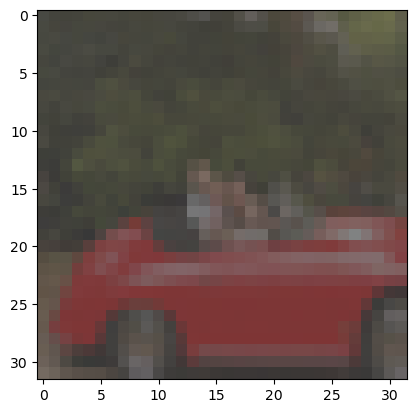

In [8]:
# visualizing a sample from train dataset
image, label = train_dataset[99]
print(label)
print(image.shape)
plt.imshow(image.permute(1,2,0))
plt.show()

tensor(7)
torch.Size([3, 32, 32])


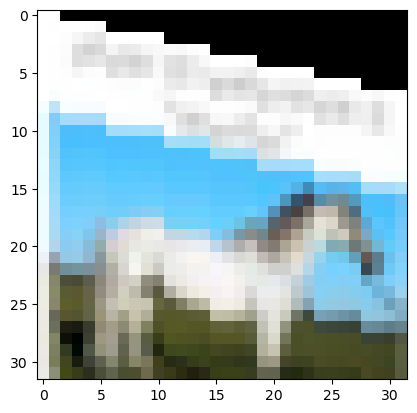

In [9]:
# visualizing a sample from train loader
# torchvision.transforms.ToTensor() converts a PIL Image or numpy.ndarray (H x W x C)
# in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
train_iter = iter(train_loader)
batch_images, batch_labels = next(train_iter)
image, label = batch_images[0], batch_labels[0]
print(label)
print(image.shape)
plt.imshow(image.permute(1,2,0))
plt.show()

## Building the model

CNN's have a typical VGG architecture that involves CONV -> CONV-> Maxpool -> .... -> FC -> ... Output

In [10]:
# construct the architecture of the CNN model
class CNN(nn.Module):
  # CIFAR-10 is 3x32x32, b is the batch size
  def __init__(self):
    super().__init__()

    # VGG MODEL
    # CONV->CONV->POOL

    # 3x32x32 -> 64x32x32
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())

    # 64x32x32 -> 64x16x16
    self.layer2 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2))

    # 64x16x16 -> 128x16x16
    self.layer3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU())

    # 128x16x16 -> 128x8x8
    self.layer4 =  nn.Sequential(
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2))

    # 128x8x8 -> 256x8x8
    self.layer5 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU())

    # 256x8x8 -> 256x4x4
    self.layer6 =  nn.Sequential(
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2))

    # bx256x4x4 ->bx(256x4x4)
    self.fc = nn.Sequential(
        nn.Flatten())

    # bx(256*4*4) -> bx256
    self.fc1 = nn.Sequential(
        nn.Linear(256*4*4, 512),
        nn.ReLU())

    # bx256 -> bx10
    self.fc2 = nn.Sequential(
        nn.Linear(512, 10))

  def forward(self, x):
    # input 3x32x32, output 32x32x32
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = self.layer6(out)
    out = self.fc(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [11]:
# Sanity check
cnn = CNN()
print(cnn(torch.randn(128, 3, 32, 32)).shape)
del cnn

torch.Size([128, 10])


In [12]:
# create an instance of CNN class
model = CNN()
model.to(device) # specify that this model will be stored on the device you chose earlier (GPU or CPU)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [13]:
# loss function
criterion = nn.CrossEntropyLoss()

In [14]:
# optimizer: adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [15]:
# reduce learning rate when a metric has stopped improving
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, min_lr=0.0001, patience=5, verbose=1)

## Training

In [16]:
# training function
def train_one_epoch(model, train_loader, optimizer, criterion, device):
  # sets the module in training mode
  model.train()

  correct = 0
  for i, batch in tqdm(enumerate(train_loader)):  # looping through
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    # bx10, want to do argmax on the "10" dimension
    predictions = outputs.argmax(dim=1)
    correct += (predictions == labels).sum().item()
    # Computes the gradients and stores it in the model parameters' .grad
    # attribute (this is backprop or autodiff)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  accuracy = 100 * correct / len(train_dataset)
  print('End of epoch train loss:', round(loss.item(), 3))
  print(f"End of epoch val accuracy: {accuracy}%")

  return loss, accuracy

## Testing

In [17]:
# validation/testing function
def test(model, test_loader, device):
  # the classes - these are from the cifar-10 dataset
  # classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  # sets the module in evaluation mode
  model.eval()

  correct = 0
  for i, batch in tqdm(enumerate(test_loader)):
    # print("i:", i)
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    # bx10, want to do argmax on the "10" dimension
    predictions = outputs.argmax(dim=1)
    correct += (predictions == labels).sum().item()

  accuracy = 100 * correct / len(test_dataset)
  print('End of epoch val loss:', round(loss.item(), 3))
  print(f"End of epoch val accuracy: {accuracy}%")

  # visualizing the current model's performance
  for i in range(5):
    print("Guess:", predictions[i], "Label:", batch_labels[i])
    print('Guess:', classes[predictions[i]], '| Label:', classes[batch_labels[i]])
    plt.imshow(inputs[i].cpu().permute(1,2,0))
    plt.show()

  return loss, accuracy

# Running the train-test loop

Epoch:  1


0it [00:00, ?it/s]

End of epoch train loss: 1.611
End of epoch val accuracy: 31.28%


0it [00:00, ?it/s]

End of epoch val loss: 1.014
End of epoch val accuracy: 52.55%
Guess: tensor(3, device='cuda:0') Label: tensor(7)
Guess: cat | Label: horse


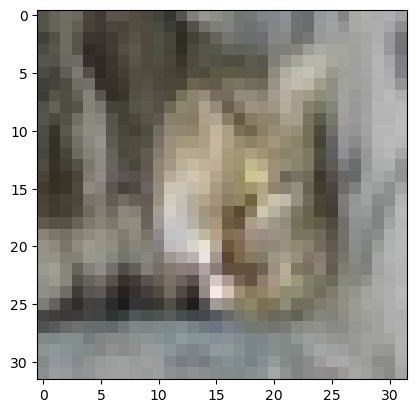

Guess: tensor(2, device='cuda:0') Label: tensor(0)
Guess: bird | Label: airplane


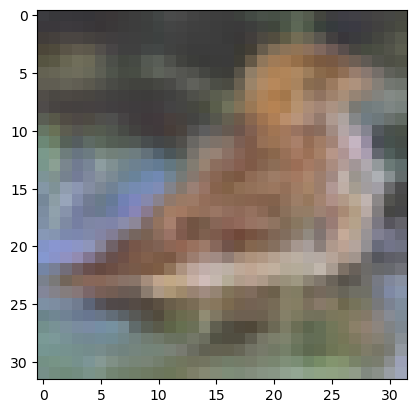

Guess: tensor(1, device='cuda:0') Label: tensor(8)
Guess: automobile | Label: ship


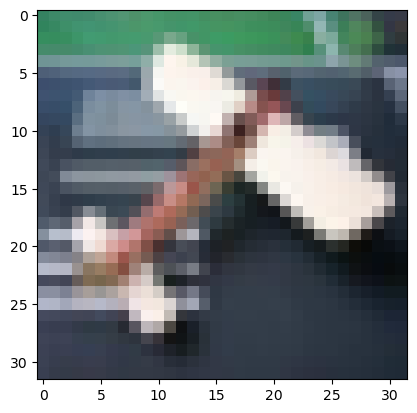

Guess: tensor(1, device='cuda:0') Label: tensor(5)
Guess: automobile | Label: dog


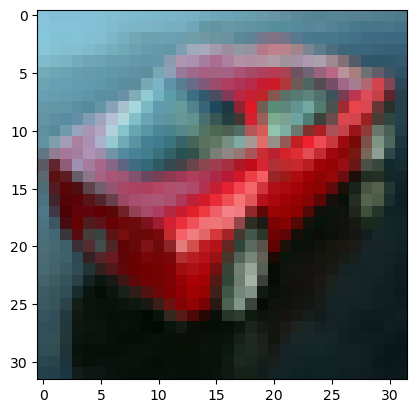

Guess: tensor(6, device='cuda:0') Label: tensor(0)
Guess: frog | Label: airplane


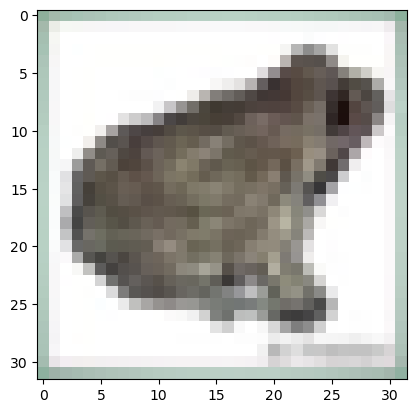

Epoch: 1 val_loss improved from inf to 1.014 , saving model to./best_model_local.pth
Epoch:  2


0it [00:00, ?it/s]

End of epoch train loss: 1.097
End of epoch val accuracy: 53.438%


0it [00:00, ?it/s]

End of epoch val loss: 0.937
End of epoch val accuracy: 61.77%
Guess: tensor(0, device='cuda:0') Label: tensor(7)
Guess: airplane | Label: horse


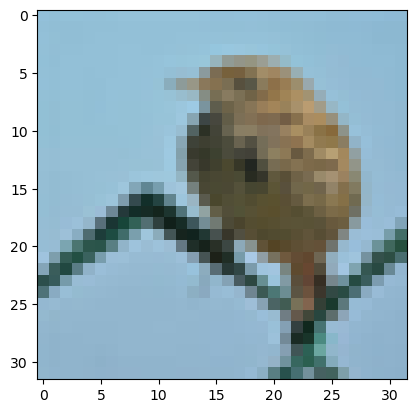

Guess: tensor(5, device='cuda:0') Label: tensor(0)
Guess: dog | Label: airplane


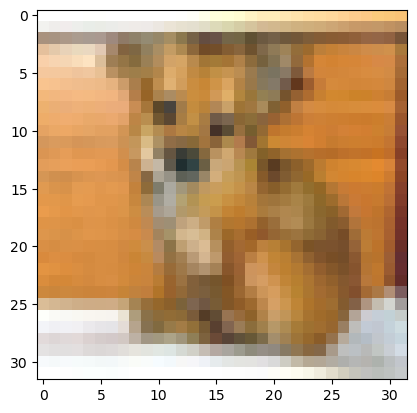

Guess: tensor(5, device='cuda:0') Label: tensor(8)
Guess: dog | Label: ship


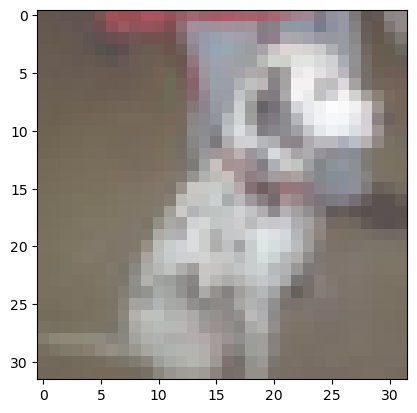

Guess: tensor(0, device='cuda:0') Label: tensor(5)
Guess: airplane | Label: dog


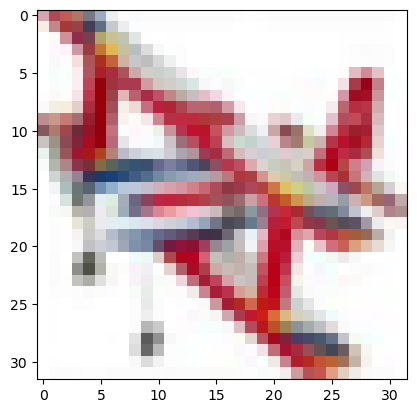

Guess: tensor(4, device='cuda:0') Label: tensor(0)
Guess: deer | Label: airplane


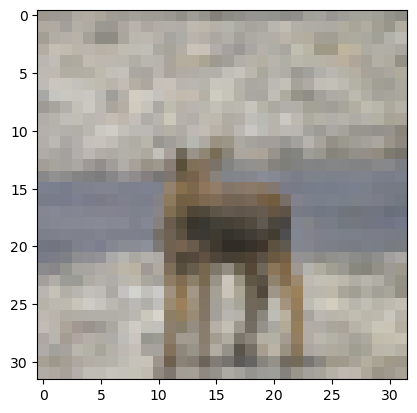

Epoch: 2 val_loss improved from 1.014 to 0.937 , saving model to./best_model_local.pth
Epoch:  3


0it [00:00, ?it/s]

End of epoch train loss: 0.856
End of epoch val accuracy: 63.228%


0it [00:00, ?it/s]

End of epoch val loss: 1.162
End of epoch val accuracy: 70.31%
Guess: tensor(5, device='cuda:0') Label: tensor(7)
Guess: dog | Label: horse


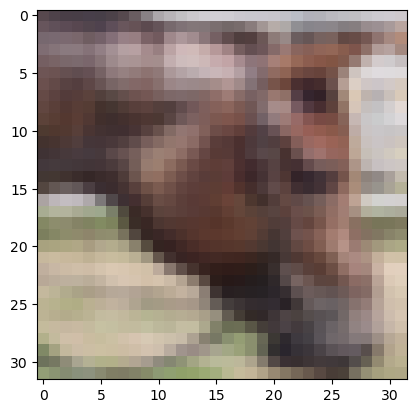

Guess: tensor(4, device='cuda:0') Label: tensor(0)
Guess: deer | Label: airplane


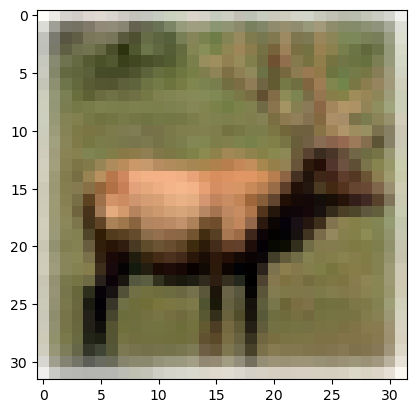

Guess: tensor(1, device='cuda:0') Label: tensor(8)
Guess: automobile | Label: ship


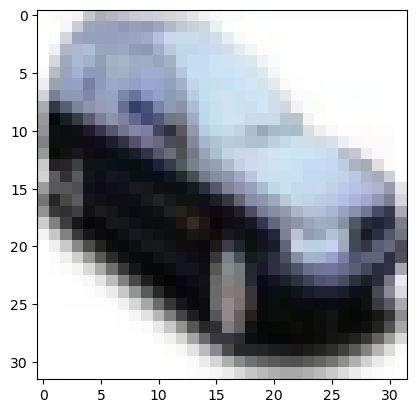

Guess: tensor(7, device='cuda:0') Label: tensor(5)
Guess: horse | Label: dog


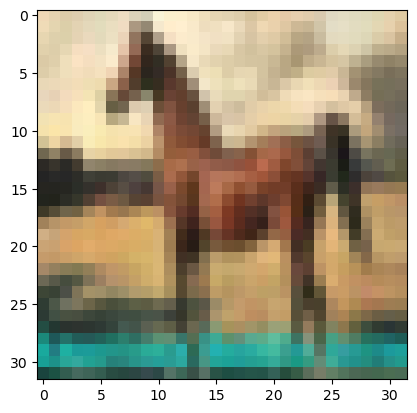

Guess: tensor(0, device='cuda:0') Label: tensor(0)
Guess: airplane | Label: airplane


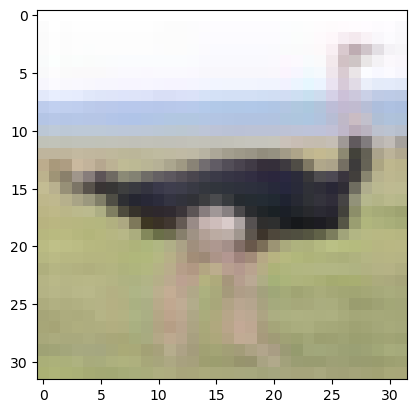

Epoch: 3 val_loss did not improve from 0.937
Epoch:  4


0it [00:00, ?it/s]

End of epoch train loss: 0.833
End of epoch val accuracy: 68.83%


0it [00:00, ?it/s]

End of epoch val loss: 1.041
End of epoch val accuracy: 72.2%
Guess: tensor(6, device='cuda:0') Label: tensor(7)
Guess: frog | Label: horse


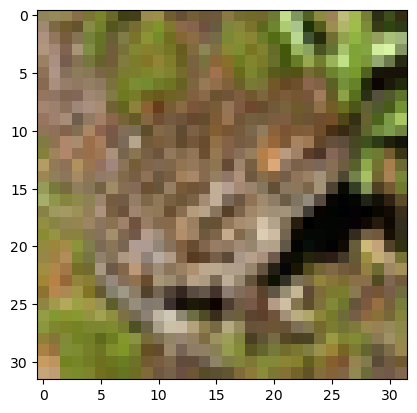

Guess: tensor(0, device='cuda:0') Label: tensor(0)
Guess: airplane | Label: airplane


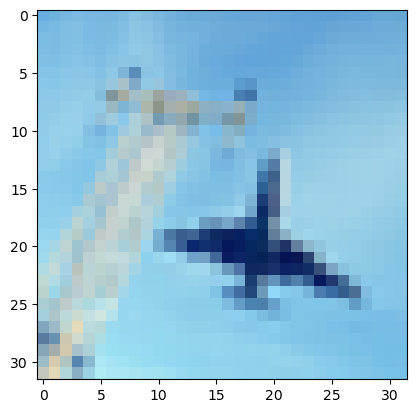

Guess: tensor(2, device='cuda:0') Label: tensor(8)
Guess: bird | Label: ship


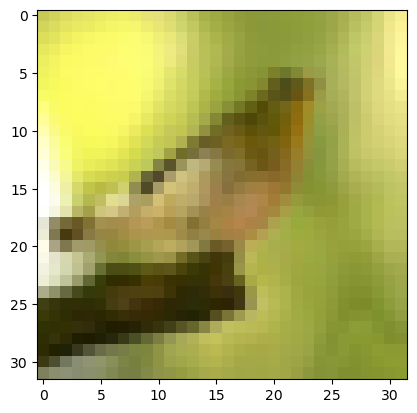

Guess: tensor(9, device='cuda:0') Label: tensor(5)
Guess: truck | Label: dog


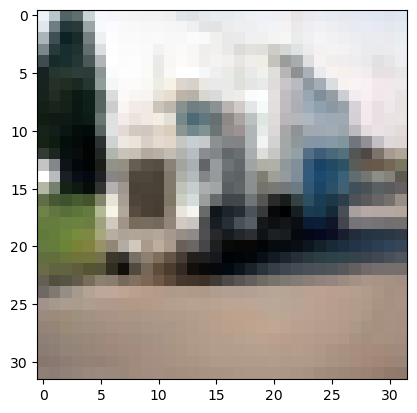

Guess: tensor(2, device='cuda:0') Label: tensor(0)
Guess: bird | Label: airplane


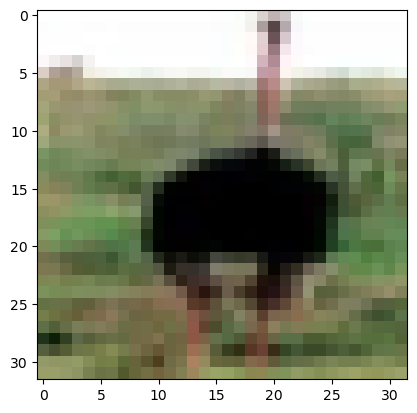

Epoch: 4 val_loss did not improve from 0.937
Epoch:  5


0it [00:00, ?it/s]

End of epoch train loss: 0.792
End of epoch val accuracy: 72.57%


0it [00:00, ?it/s]

End of epoch val loss: 0.647
End of epoch val accuracy: 78.34%
Guess: tensor(7, device='cuda:0') Label: tensor(7)
Guess: horse | Label: horse


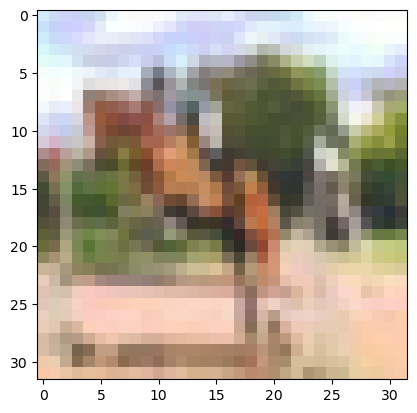

Guess: tensor(4, device='cuda:0') Label: tensor(0)
Guess: deer | Label: airplane


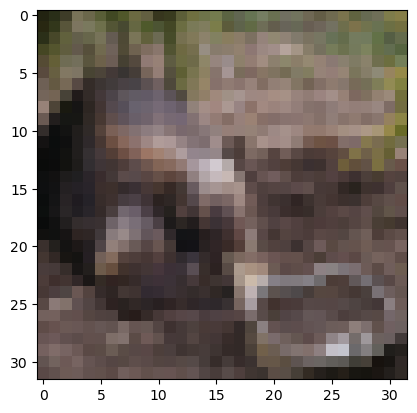

Guess: tensor(8, device='cuda:0') Label: tensor(8)
Guess: ship | Label: ship


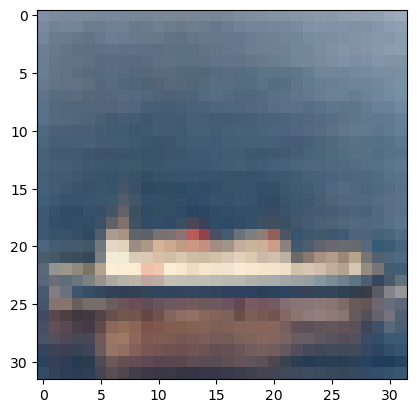

Guess: tensor(4, device='cuda:0') Label: tensor(5)
Guess: deer | Label: dog


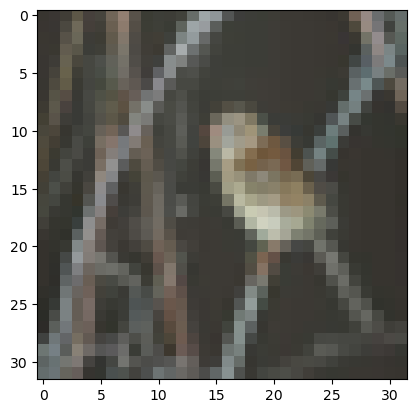

Guess: tensor(6, device='cuda:0') Label: tensor(0)
Guess: frog | Label: airplane


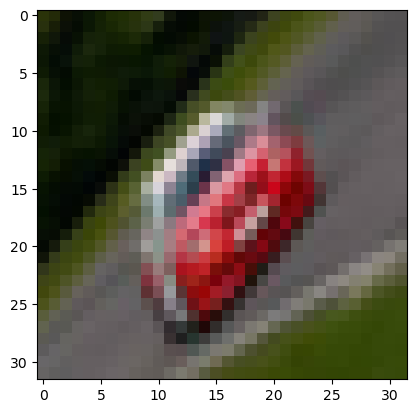

Epoch: 5 val_loss improved from 0.937 to 0.647 , saving model to./best_model_local.pth
Epoch:  6


0it [00:00, ?it/s]

End of epoch train loss: 0.626
End of epoch val accuracy: 75.114%


0it [00:00, ?it/s]

End of epoch val loss: 0.593
End of epoch val accuracy: 76.75%
Guess: tensor(2, device='cuda:0') Label: tensor(7)
Guess: bird | Label: horse


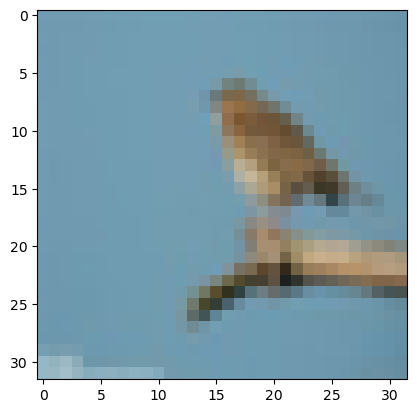

Guess: tensor(7, device='cuda:0') Label: tensor(0)
Guess: horse | Label: airplane


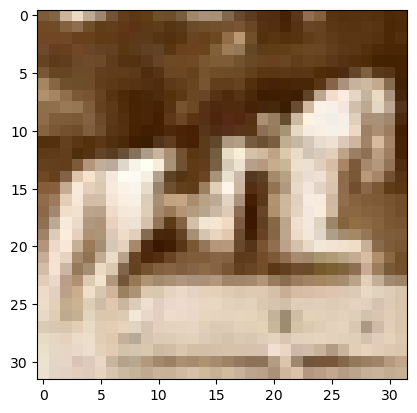

Guess: tensor(4, device='cuda:0') Label: tensor(8)
Guess: deer | Label: ship


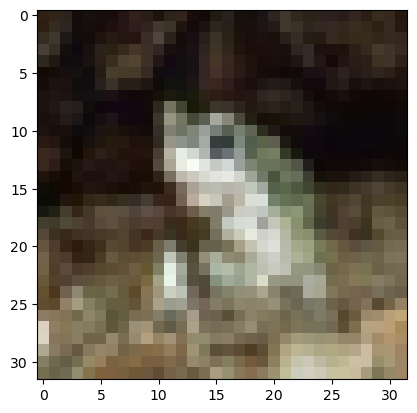

Guess: tensor(6, device='cuda:0') Label: tensor(5)
Guess: frog | Label: dog


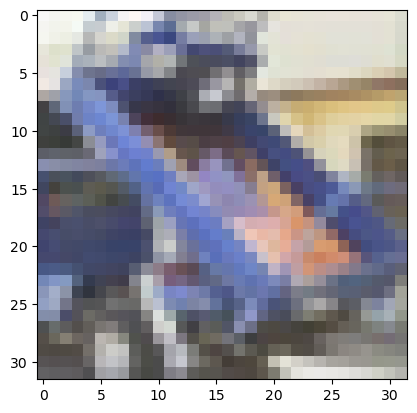

Guess: tensor(8, device='cuda:0') Label: tensor(0)
Guess: ship | Label: airplane


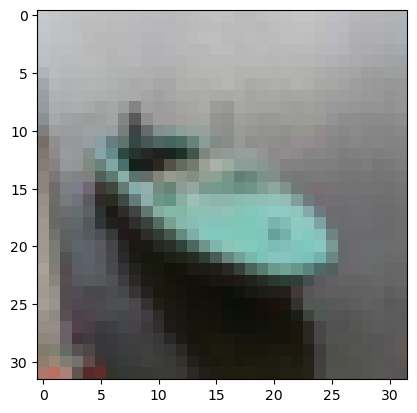

Epoch: 6 val_loss improved from 0.647 to 0.593 , saving model to./best_model_local.pth
Epoch:  7


0it [00:00, ?it/s]

End of epoch train loss: 0.631
End of epoch val accuracy: 77.58%


0it [00:00, ?it/s]

End of epoch val loss: 0.688
End of epoch val accuracy: 80.32%
Guess: tensor(3, device='cuda:0') Label: tensor(7)
Guess: cat | Label: horse


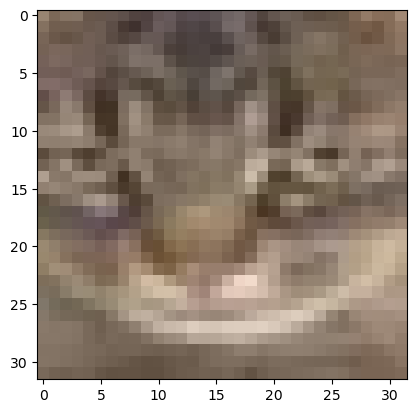

Guess: tensor(7, device='cuda:0') Label: tensor(0)
Guess: horse | Label: airplane


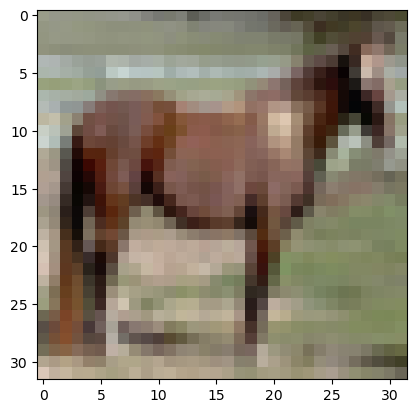

Guess: tensor(1, device='cuda:0') Label: tensor(8)
Guess: automobile | Label: ship


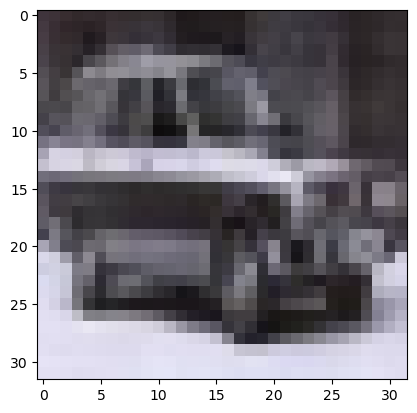

Guess: tensor(4, device='cuda:0') Label: tensor(5)
Guess: deer | Label: dog


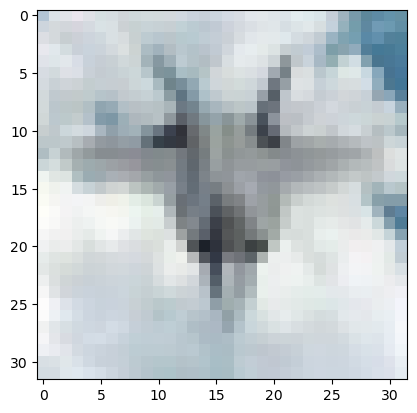

Guess: tensor(7, device='cuda:0') Label: tensor(0)
Guess: horse | Label: airplane


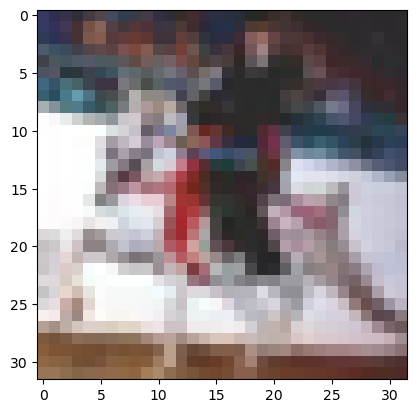

Epoch: 7 val_loss did not improve from 0.593
Epoch:  8


0it [00:00, ?it/s]

End of epoch train loss: 0.586
End of epoch val accuracy: 79.292%


0it [00:00, ?it/s]

End of epoch val loss: 0.494
End of epoch val accuracy: 80.35%
Guess: tensor(9, device='cuda:0') Label: tensor(7)
Guess: truck | Label: horse


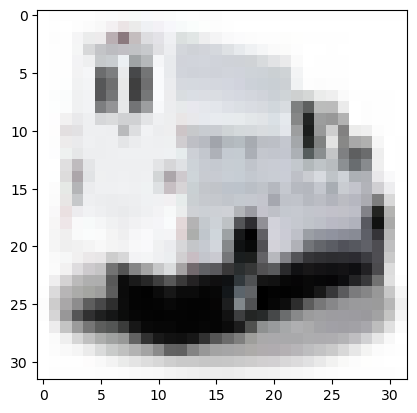

Guess: tensor(3, device='cuda:0') Label: tensor(0)
Guess: cat | Label: airplane


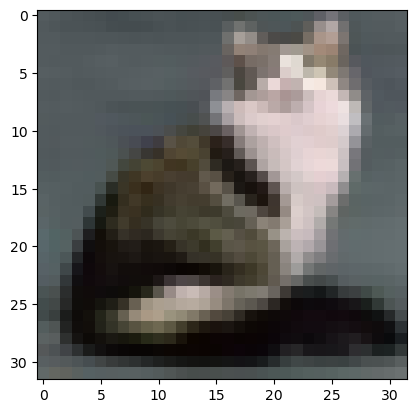

Guess: tensor(5, device='cuda:0') Label: tensor(8)
Guess: dog | Label: ship


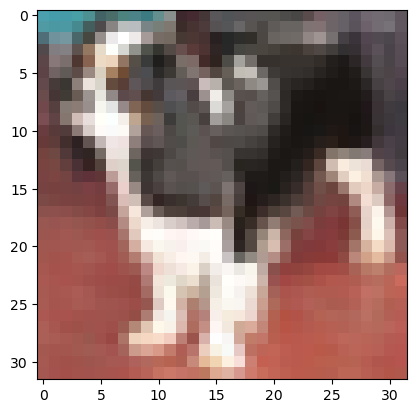

Guess: tensor(9, device='cuda:0') Label: tensor(5)
Guess: truck | Label: dog


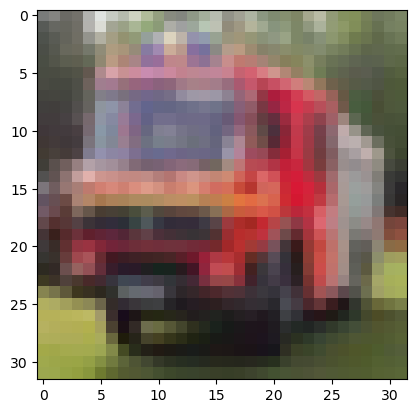

Guess: tensor(4, device='cuda:0') Label: tensor(0)
Guess: deer | Label: airplane


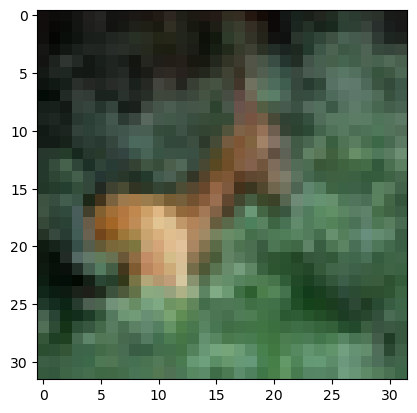

Epoch: 8 val_loss improved from 0.593 to 0.494 , saving model to./best_model_local.pth
Epoch:  9


0it [00:00, ?it/s]

End of epoch train loss: 0.489
End of epoch val accuracy: 81.052%


0it [00:00, ?it/s]

End of epoch val loss: 0.346
End of epoch val accuracy: 84.45%
Guess: tensor(3, device='cuda:0') Label: tensor(7)
Guess: cat | Label: horse


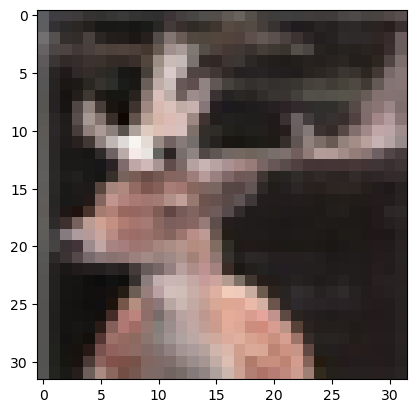

Guess: tensor(1, device='cuda:0') Label: tensor(0)
Guess: automobile | Label: airplane


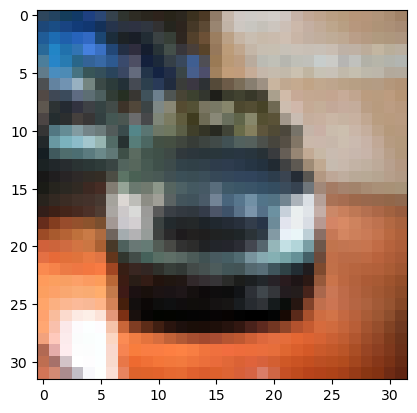

Guess: tensor(7, device='cuda:0') Label: tensor(8)
Guess: horse | Label: ship


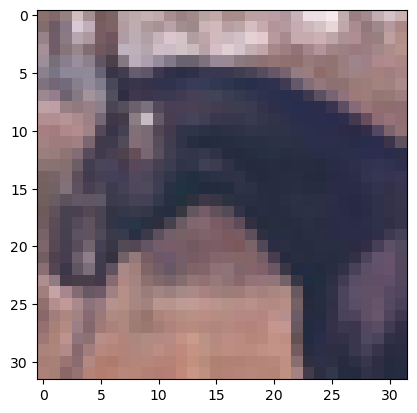

Guess: tensor(1, device='cuda:0') Label: tensor(5)
Guess: automobile | Label: dog


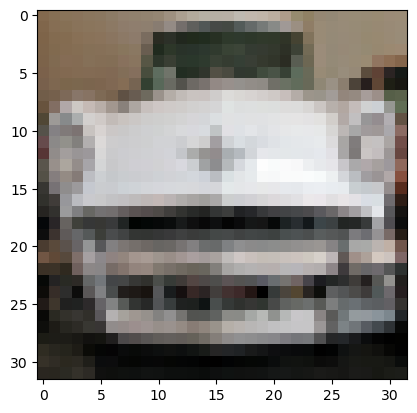

Guess: tensor(7, device='cuda:0') Label: tensor(0)
Guess: horse | Label: airplane


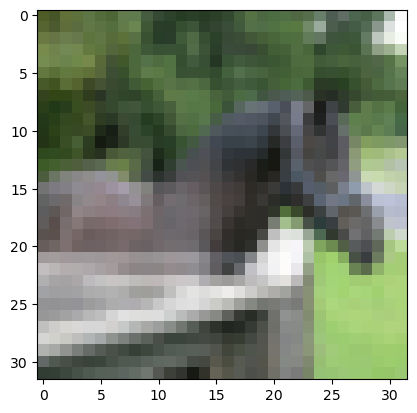

Epoch: 9 val_loss improved from 0.494 to 0.346 , saving model to./best_model_local.pth
Epoch:  10


0it [00:00, ?it/s]

End of epoch train loss: 0.421
End of epoch val accuracy: 82.63%


0it [00:00, ?it/s]

End of epoch val loss: 0.573
End of epoch val accuracy: 81.02%
Guess: tensor(0, device='cuda:0') Label: tensor(7)
Guess: airplane | Label: horse


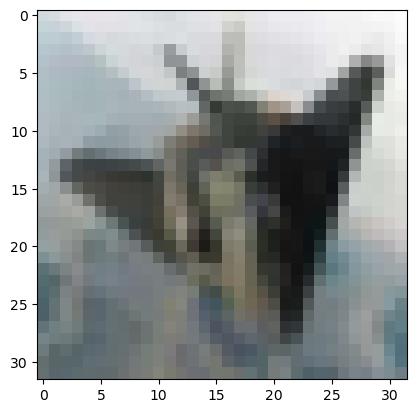

Guess: tensor(7, device='cuda:0') Label: tensor(0)
Guess: horse | Label: airplane


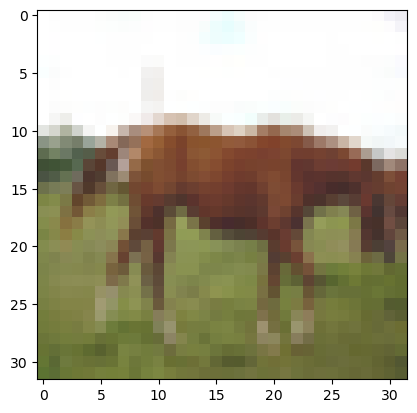

Guess: tensor(6, device='cuda:0') Label: tensor(8)
Guess: frog | Label: ship


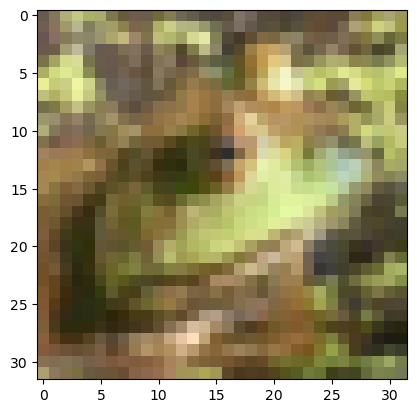

Guess: tensor(1, device='cuda:0') Label: tensor(5)
Guess: automobile | Label: dog


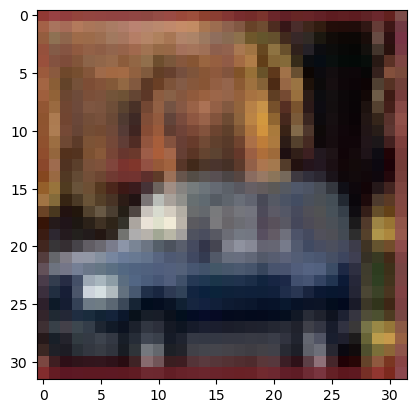

Guess: tensor(8, device='cuda:0') Label: tensor(0)
Guess: ship | Label: airplane


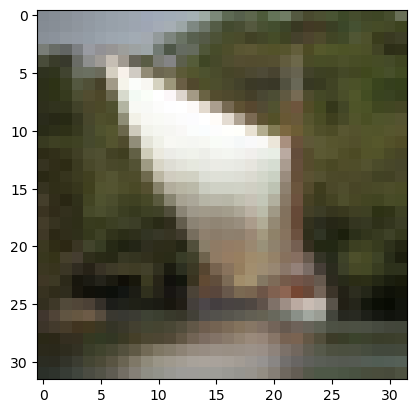

Epoch: 10 val_loss did not improve from 0.346
Epoch:  11


0it [00:00, ?it/s]

End of epoch train loss: 0.527
End of epoch val accuracy: 83.646%


0it [00:00, ?it/s]

End of epoch val loss: 0.807
End of epoch val accuracy: 83.63%
Guess: tensor(6, device='cuda:0') Label: tensor(7)
Guess: frog | Label: horse


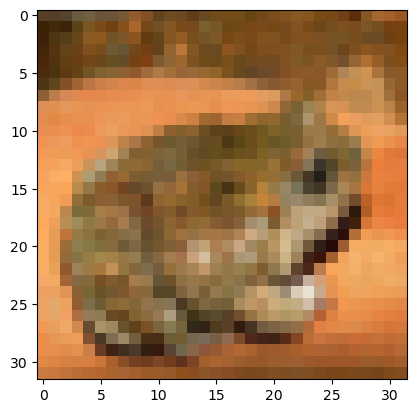

Guess: tensor(4, device='cuda:0') Label: tensor(0)
Guess: deer | Label: airplane


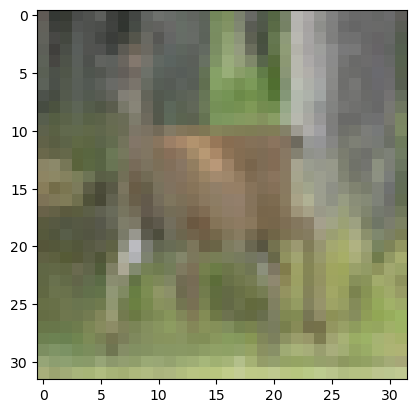

Guess: tensor(3, device='cuda:0') Label: tensor(8)
Guess: cat | Label: ship


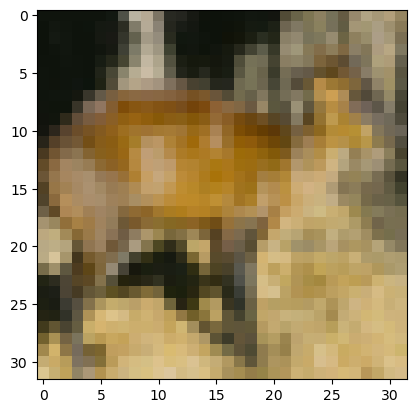

Guess: tensor(1, device='cuda:0') Label: tensor(5)
Guess: automobile | Label: dog


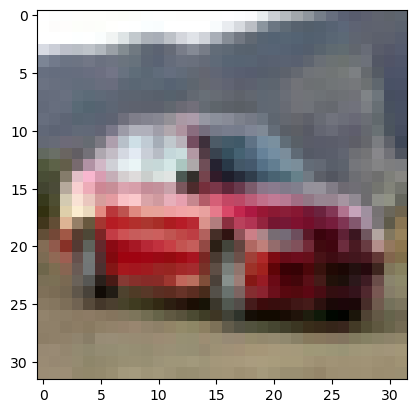

Guess: tensor(0, device='cuda:0') Label: tensor(0)
Guess: airplane | Label: airplane


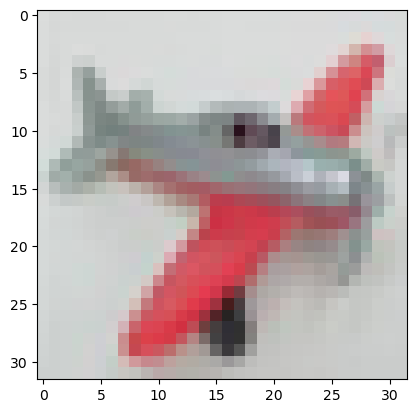

Epoch: 11 val_loss did not improve from 0.346
Epoch:  12


0it [00:00, ?it/s]

End of epoch train loss: 0.402
End of epoch val accuracy: 84.814%


0it [00:00, ?it/s]

End of epoch val loss: 0.205
End of epoch val accuracy: 83.72%
Guess: tensor(7, device='cuda:0') Label: tensor(7)
Guess: horse | Label: horse


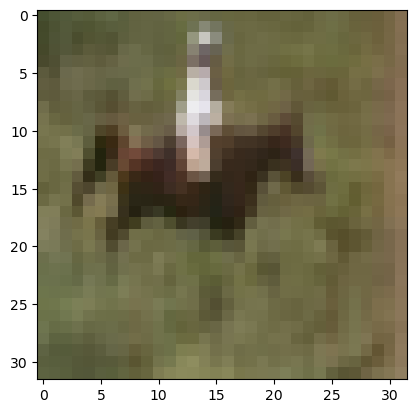

Guess: tensor(2, device='cuda:0') Label: tensor(0)
Guess: bird | Label: airplane


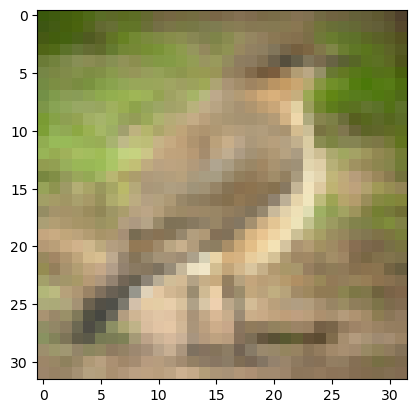

Guess: tensor(1, device='cuda:0') Label: tensor(8)
Guess: automobile | Label: ship


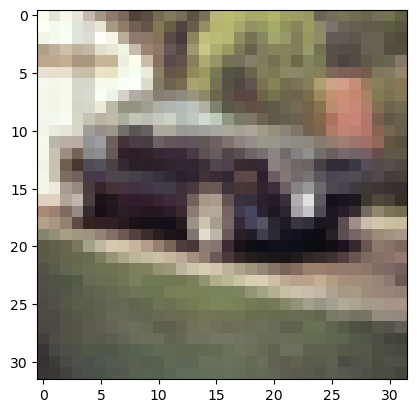

Guess: tensor(2, device='cuda:0') Label: tensor(5)
Guess: bird | Label: dog


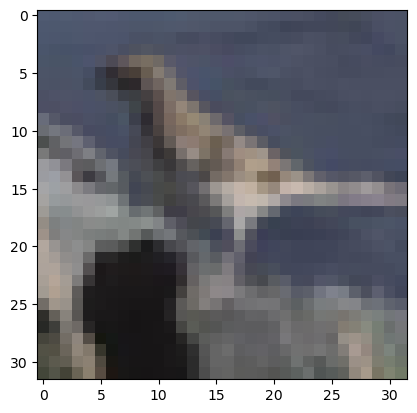

Guess: tensor(5, device='cuda:0') Label: tensor(0)
Guess: dog | Label: airplane


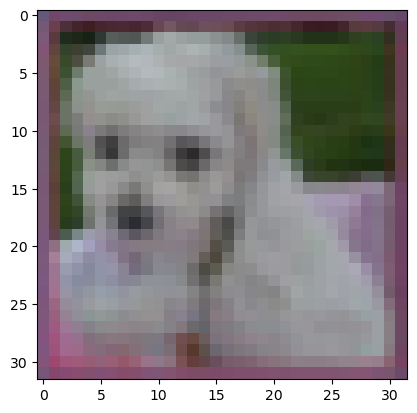

Epoch: 12 val_loss improved from 0.346 to 0.205 , saving model to./best_model_local.pth
Epoch:  13


0it [00:00, ?it/s]

End of epoch train loss: 0.392
End of epoch val accuracy: 85.662%


0it [00:00, ?it/s]

End of epoch val loss: 0.327
End of epoch val accuracy: 82.19%
Guess: tensor(4, device='cuda:0') Label: tensor(7)
Guess: deer | Label: horse


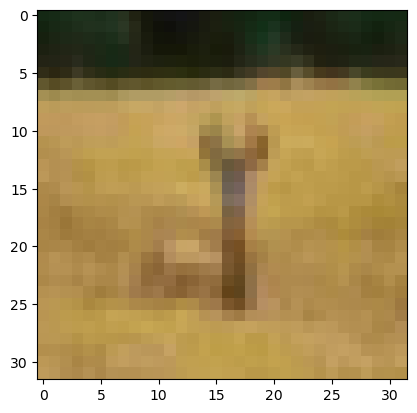

Guess: tensor(3, device='cuda:0') Label: tensor(0)
Guess: cat | Label: airplane


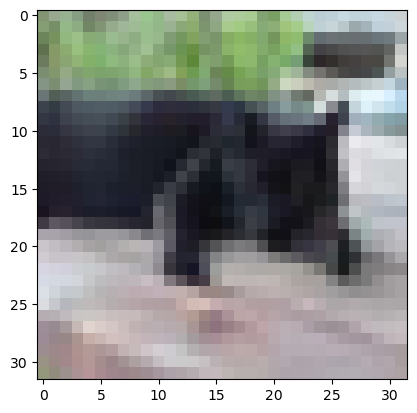

Guess: tensor(0, device='cuda:0') Label: tensor(8)
Guess: airplane | Label: ship


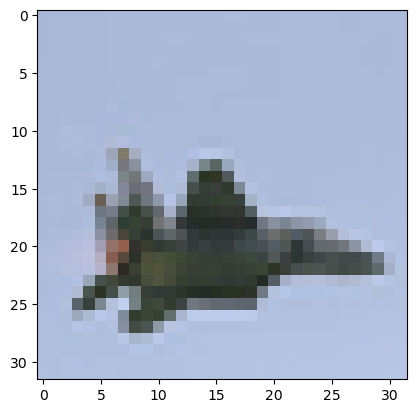

Guess: tensor(7, device='cuda:0') Label: tensor(5)
Guess: horse | Label: dog


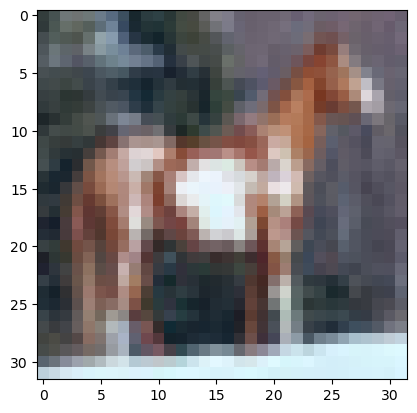

Guess: tensor(2, device='cuda:0') Label: tensor(0)
Guess: bird | Label: airplane


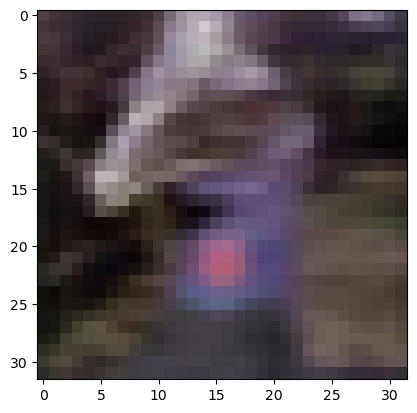

Epoch: 13 val_loss did not improve from 0.205
Epoch:  14


0it [00:00, ?it/s]

End of epoch train loss: 0.403
End of epoch val accuracy: 86.872%


0it [00:00, ?it/s]

End of epoch val loss: 0.427
End of epoch val accuracy: 84.15%
Guess: tensor(0, device='cuda:0') Label: tensor(7)
Guess: airplane | Label: horse


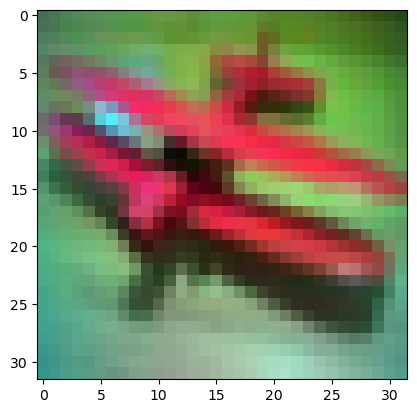

Guess: tensor(5, device='cuda:0') Label: tensor(0)
Guess: dog | Label: airplane


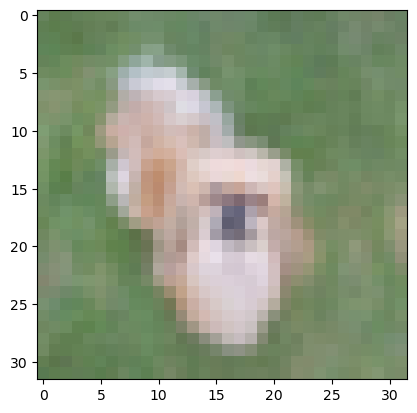

Guess: tensor(5, device='cuda:0') Label: tensor(8)
Guess: dog | Label: ship


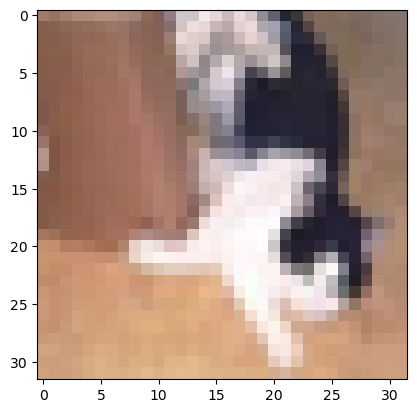

Guess: tensor(0, device='cuda:0') Label: tensor(5)
Guess: airplane | Label: dog


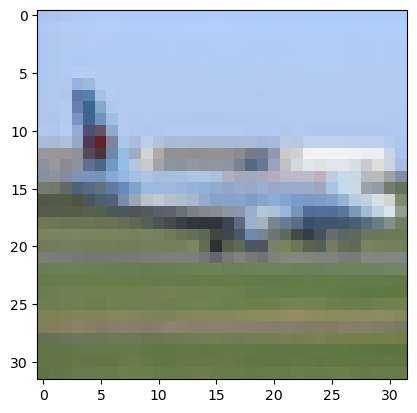

Guess: tensor(9, device='cuda:0') Label: tensor(0)
Guess: truck | Label: airplane


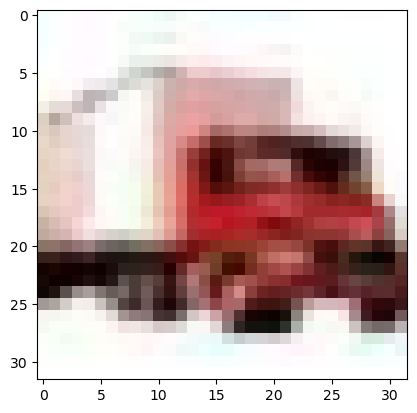

Epoch: 14 val_loss did not improve from 0.205
Epoch:  15


0it [00:00, ?it/s]

End of epoch train loss: 0.339
End of epoch val accuracy: 87.798%


0it [00:00, ?it/s]

End of epoch val loss: 0.306
End of epoch val accuracy: 84.75%
Guess: tensor(0, device='cuda:0') Label: tensor(7)
Guess: airplane | Label: horse


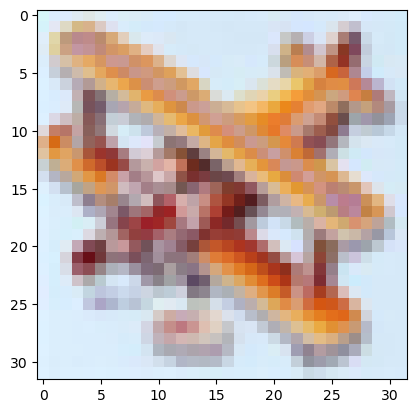

Guess: tensor(9, device='cuda:0') Label: tensor(0)
Guess: truck | Label: airplane


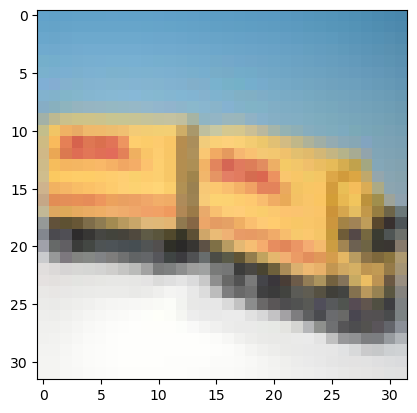

Guess: tensor(4, device='cuda:0') Label: tensor(8)
Guess: deer | Label: ship


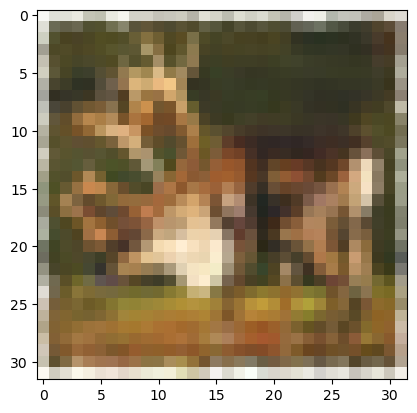

Guess: tensor(5, device='cuda:0') Label: tensor(5)
Guess: dog | Label: dog


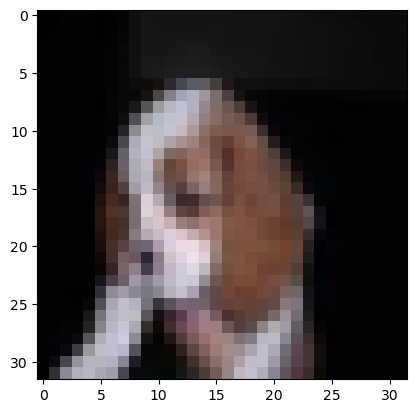

Guess: tensor(8, device='cuda:0') Label: tensor(0)
Guess: ship | Label: airplane


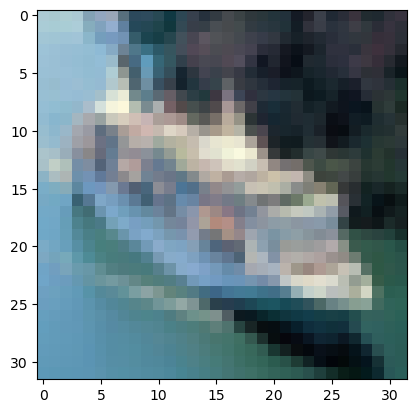

Epoch: 15 val_loss did not improve from 0.205
Epoch:  16


0it [00:00, ?it/s]

End of epoch train loss: 0.409
End of epoch val accuracy: 88.352%


0it [00:00, ?it/s]

End of epoch val loss: 0.757
End of epoch val accuracy: 85.08%
Guess: tensor(2, device='cuda:0') Label: tensor(7)
Guess: bird | Label: horse


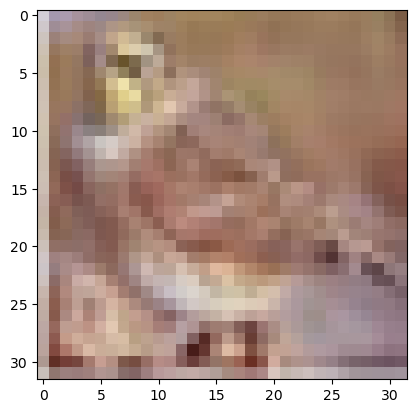

Guess: tensor(8, device='cuda:0') Label: tensor(0)
Guess: ship | Label: airplane


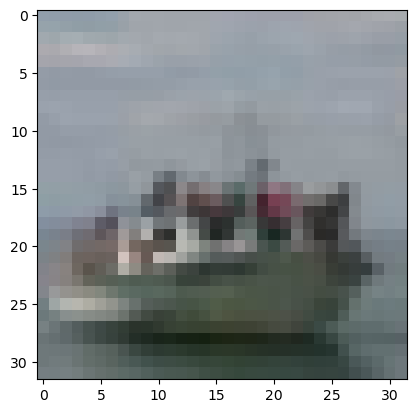

Guess: tensor(0, device='cuda:0') Label: tensor(8)
Guess: airplane | Label: ship


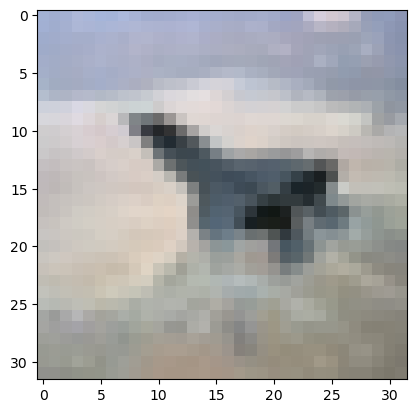

Guess: tensor(4, device='cuda:0') Label: tensor(5)
Guess: deer | Label: dog


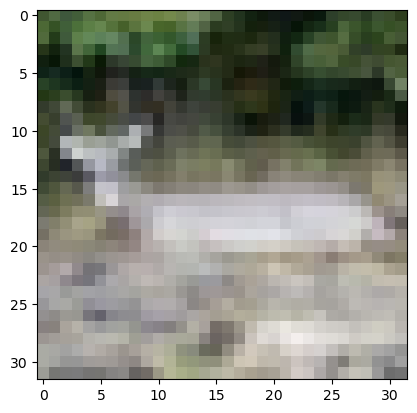

Guess: tensor(4, device='cuda:0') Label: tensor(0)
Guess: deer | Label: airplane


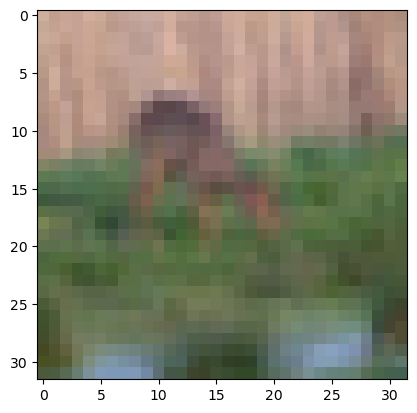

Epoch: 16 val_loss did not improve from 0.205
Epoch:  17


0it [00:00, ?it/s]

End of epoch train loss: 0.383
End of epoch val accuracy: 88.862%


0it [00:00, ?it/s]

End of epoch val loss: 0.132
End of epoch val accuracy: 84.88%
Guess: tensor(0, device='cuda:0') Label: tensor(7)
Guess: airplane | Label: horse


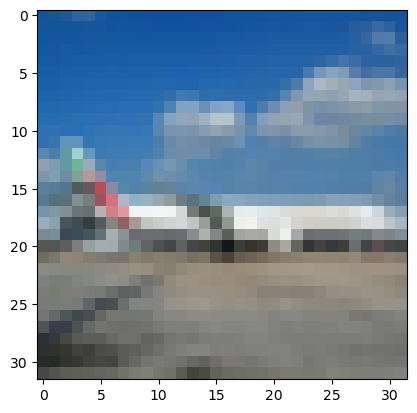

Guess: tensor(5, device='cuda:0') Label: tensor(0)
Guess: dog | Label: airplane


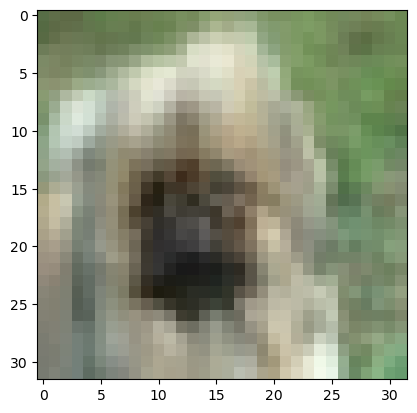

Guess: tensor(4, device='cuda:0') Label: tensor(8)
Guess: deer | Label: ship


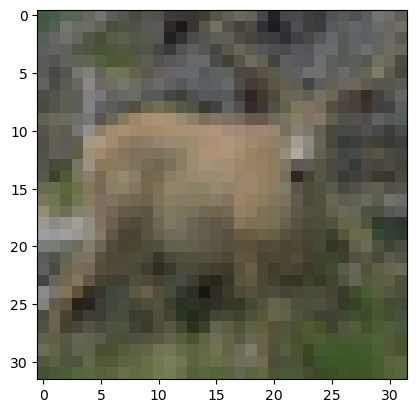

Guess: tensor(5, device='cuda:0') Label: tensor(5)
Guess: dog | Label: dog


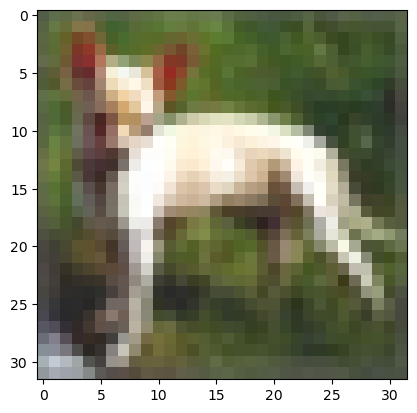

Guess: tensor(6, device='cuda:0') Label: tensor(0)
Guess: frog | Label: airplane


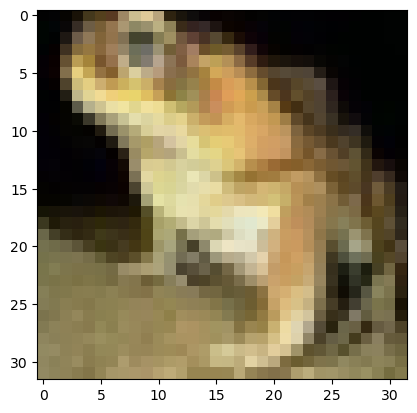

Epoch: 17 val_loss improved from 0.205 to 0.132 , saving model to./best_model_local.pth
Epoch:  18


0it [00:00, ?it/s]

End of epoch train loss: 0.22
End of epoch val accuracy: 89.486%


0it [00:00, ?it/s]

End of epoch val loss: 0.159
End of epoch val accuracy: 85.76%
Guess: tensor(1, device='cuda:0') Label: tensor(7)
Guess: automobile | Label: horse


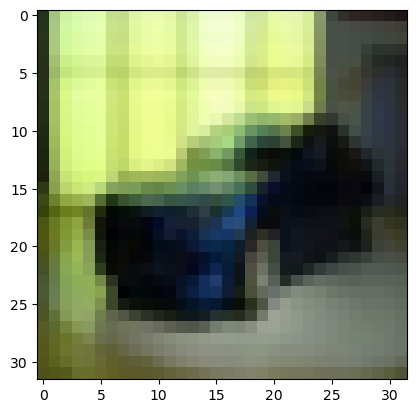

Guess: tensor(8, device='cuda:0') Label: tensor(0)
Guess: ship | Label: airplane


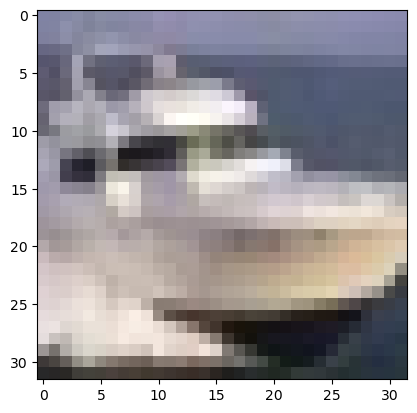

Guess: tensor(1, device='cuda:0') Label: tensor(8)
Guess: automobile | Label: ship


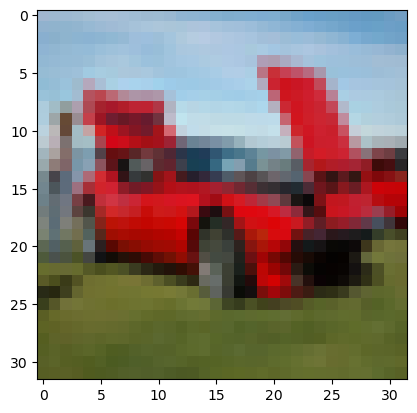

Guess: tensor(1, device='cuda:0') Label: tensor(5)
Guess: automobile | Label: dog


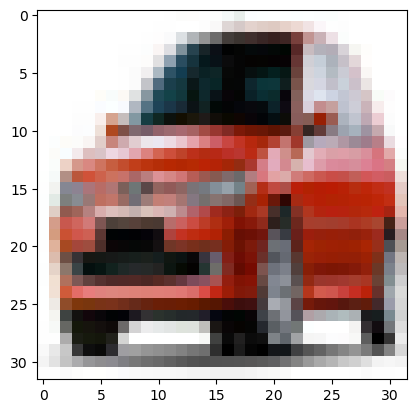

Guess: tensor(6, device='cuda:0') Label: tensor(0)
Guess: frog | Label: airplane


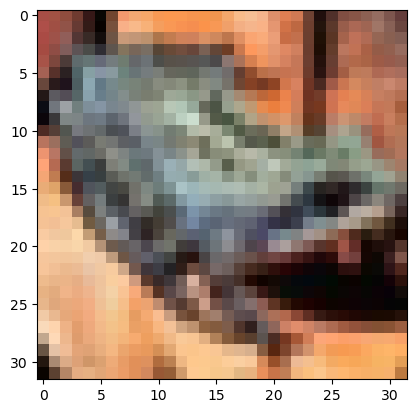

Epoch: 18 val_loss did not improve from 0.132
Epoch:  19


0it [00:00, ?it/s]

End of epoch train loss: 0.359
End of epoch val accuracy: 89.824%


0it [00:00, ?it/s]

End of epoch val loss: 0.643
End of epoch val accuracy: 86.35%
Guess: tensor(0, device='cuda:0') Label: tensor(7)
Guess: airplane | Label: horse


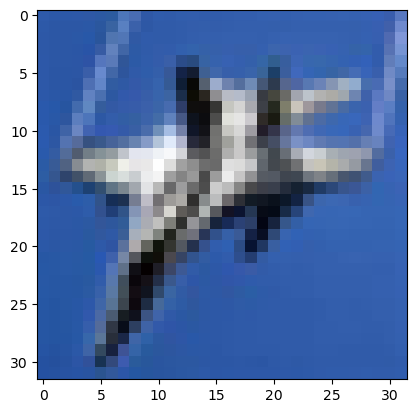

Guess: tensor(5, device='cuda:0') Label: tensor(0)
Guess: dog | Label: airplane


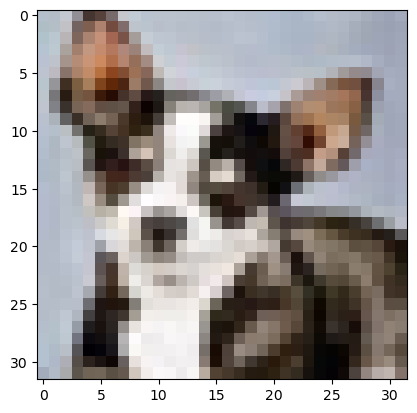

Guess: tensor(5, device='cuda:0') Label: tensor(8)
Guess: dog | Label: ship


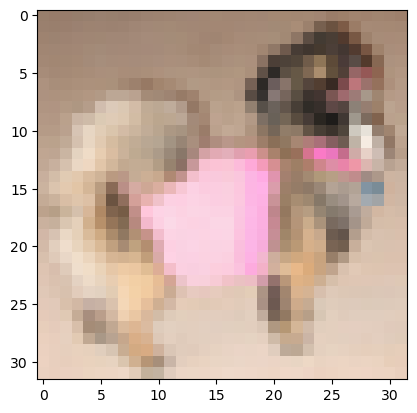

Guess: tensor(4, device='cuda:0') Label: tensor(5)
Guess: deer | Label: dog


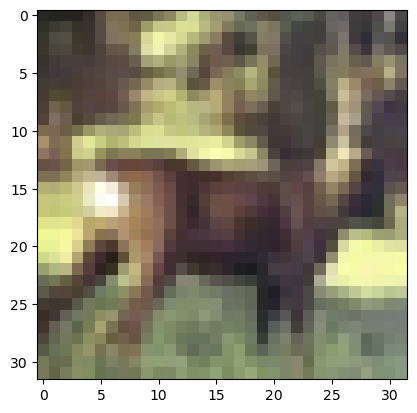

Guess: tensor(3, device='cuda:0') Label: tensor(0)
Guess: cat | Label: airplane


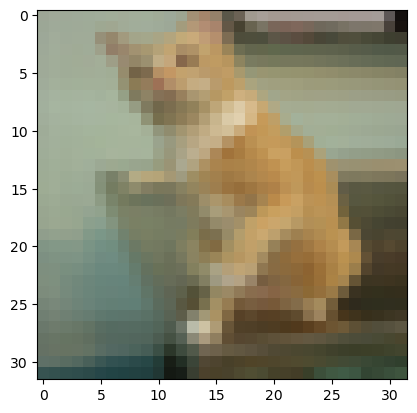

Epoch: 19 val_loss did not improve from 0.132
Epoch:  20


0it [00:00, ?it/s]

End of epoch train loss: 0.216
End of epoch val accuracy: 90.53%


0it [00:00, ?it/s]

End of epoch val loss: 0.14
End of epoch val accuracy: 86.38%
Guess: tensor(6, device='cuda:0') Label: tensor(7)
Guess: frog | Label: horse


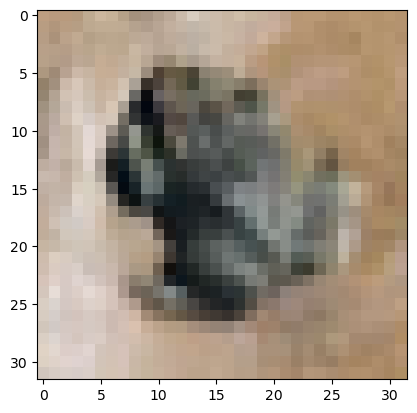

Guess: tensor(7, device='cuda:0') Label: tensor(0)
Guess: horse | Label: airplane


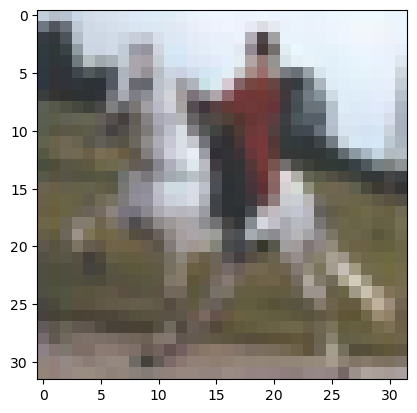

Guess: tensor(6, device='cuda:0') Label: tensor(8)
Guess: frog | Label: ship


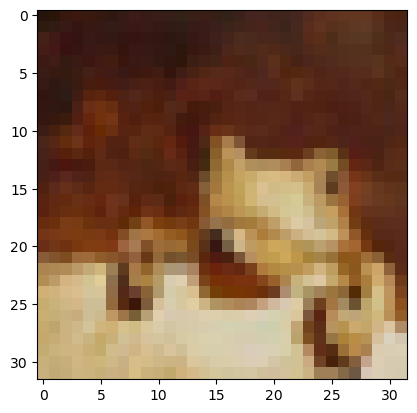

Guess: tensor(1, device='cuda:0') Label: tensor(5)
Guess: automobile | Label: dog


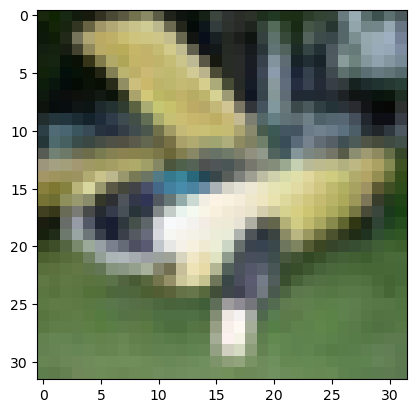

Guess: tensor(0, device='cuda:0') Label: tensor(0)
Guess: airplane | Label: airplane


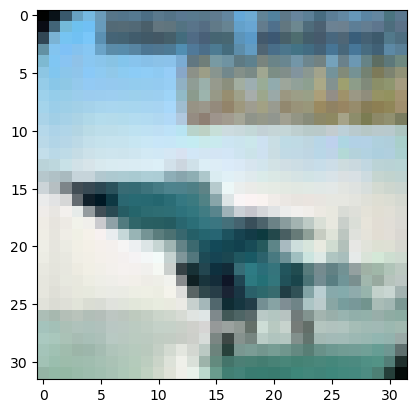

Epoch: 20 val_loss did not improve from 0.132
Training time: 623.467446565628


In [ ]:
# run a loop which calls the training and testing functions
NUM_EPOCHS = 20

# parameters for early stopping
start_from_epoch = 10
patience = 5
counter = 0

# best val loss
best_loss = float('inf')
best_epoch = -1

# save the loss and accuracy for plotting later
df_loss = pd.DataFrame(columns=['train', 'validation'])
df_acc = pd.DataFrame(columns=['train', 'validation'])

t0 = time.time()
for epoch in range(NUM_EPOCHS):
  print("Epoch: ", epoch + 1)

  # train the model
  loss1, accuracy1 = train_one_epoch(model, train_loader, optimizer, criterion, device)

  # test the model
  loss2, accuracy2 = test(model, test_loader, device)

  # save the loss and accuracy of the epoch
  df_loss.loc[len(df_loss.index)] = [loss1.item(), loss2.item()]
  df_acc.loc[len(df_acc.index)] = [accuracy1, accuracy2]

  # reduce learning rate if val_loss has stopped improving
  scheduler.step(loss2)

  # save the best (val_loss) model
  val_loss = round(loss2.item(), 3)
  if epoch == 0 or val_loss < best_loss:
    # val_loss improved from the best val loss
    print("Epoch:", str(epoch + 1), "val_loss improved from", str(best_loss),
          "to", str(val_loss), ", saving model to" +
          "./best_model_local.pth")
    torch.save(model.state_dict(), "./best_model_local.pth")
    best_loss = val_loss
    best_epoch = epoch;
    counter = 0
  else:
    # val_loss did not improve from the best val_loss
    print("Epoch:", str(epoch + 1), "val_loss did not improve from", str(best_loss))
    counter += 1
    # early stopping the tran-test loop
    if epoch >= start_from_epoch and counter > patience:
      print("Epoch:", str(epoch + 1), "early stopping", "best epoch:", best_epoch)
      break

print("Training time:", time.time()-t0)

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

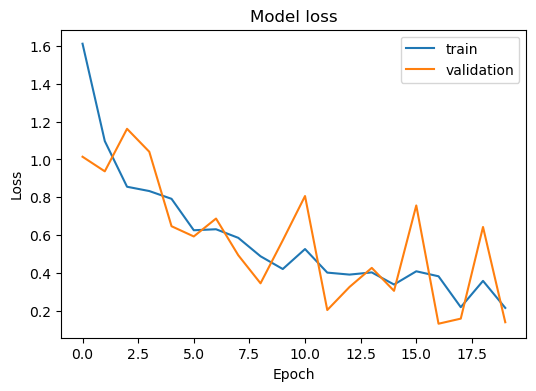

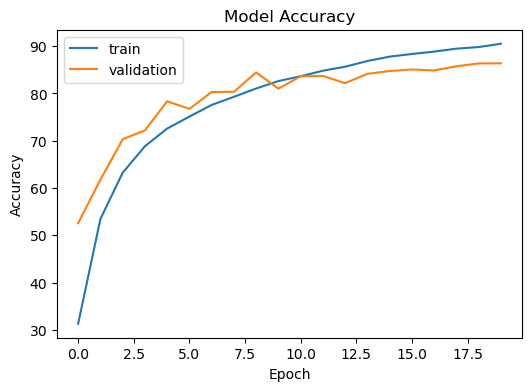

In [ ]:
# plot train and validation loss and accuracy graph
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(6,4)).set(xlabel='Epoch',ylabel='Accuracy')

In [ ]:
size = 0
for param in model.parameters():
  size += np.prod(param.shape)
print(f"Number of parameters: {size}")

Number of parameters: 3249994


## Saving the weights

In [ ]:
# save the weights of the model
torch.save(model.state_dict(), "./best_model_local.pth")

## Loading the weights

In [ ]:
# reload the weights previously saved
model_new = CNN()
model_new.load_state_dict(torch.load("./best_model_local.pth"))
model.to(device)
model.eval()

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

0it [00:00, ?it/s]

End of epoch val loss: 0.734
End of epoch val accuracy: 86.38%
Guess: tensor(4, device='cuda:0') Label: tensor(7)
Guess: deer | Label: horse


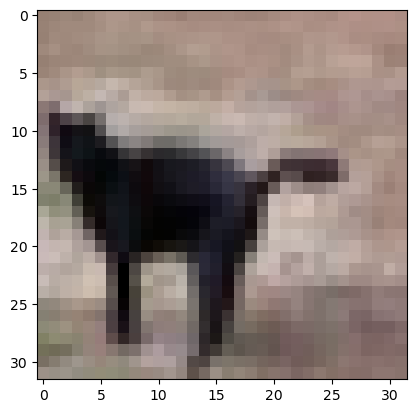

Guess: tensor(0, device='cuda:0') Label: tensor(0)
Guess: airplane | Label: airplane


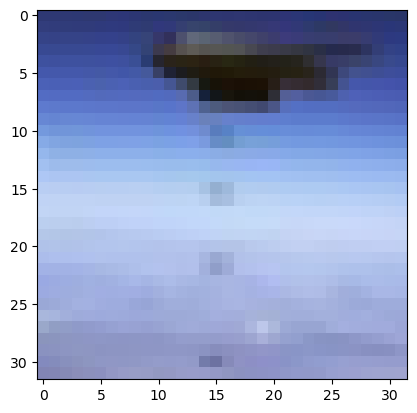

Guess: tensor(4, device='cuda:0') Label: tensor(8)
Guess: deer | Label: ship


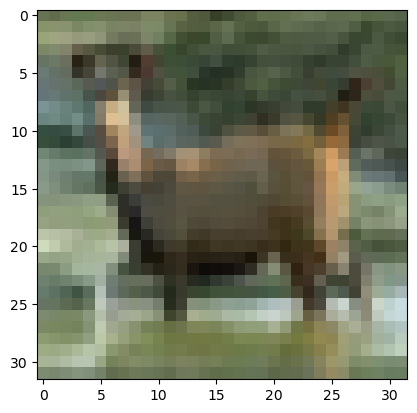

Guess: tensor(6, device='cuda:0') Label: tensor(5)
Guess: frog | Label: dog


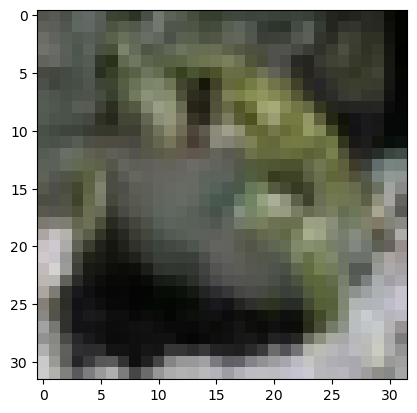

Guess: tensor(8, device='cuda:0') Label: tensor(0)
Guess: ship | Label: airplane


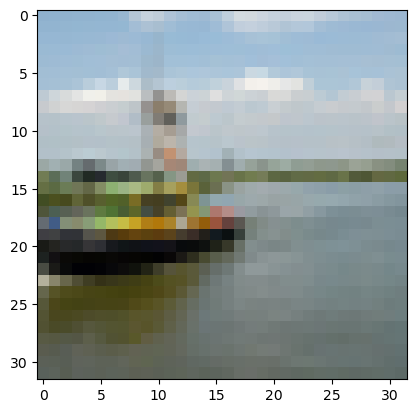

(tensor(0.7339, device='cuda:0', grad_fn=<NllLossBackward0>), 86.38)

In [ ]:
# test the model
test(model, test_loader, device)